In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<h1>Data Collection</h1>

Amazon Data : Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

Features:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


Features:

- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



<h3> TO DO LIST </h3>

In the followings statements, 'extracted' means filtered with the thema : products/reviews associated to bio/ecology/renewable etc...

- Choose category to focus on : Books ? / Health Care ....
- Show Proportion of extracted data compared to the full data (of the category)
- Comparison of extracted data between categories (which one contains the most related products/review interest)
- Distribution Price of extracted data (per category) --> Compare between category and with not extracted data in the same category
- Distribution salesRank of extracted data (best per category, mean, proportion of 10% first, 20%first etc...) --> Compare between category and with not extracted data in the same category

- __Keywords__ : How to efficiently implement the selection of related data ? Currently with a list of key words, can use regexp, better writing of keywords etc.. ?

- Associate Metadata with Reviews : __Join__
> - Extract year of 1st review (which will give the publication year of the product -approximately-)
> - Histograms number of extracted products per year 
> - Histograms number of extracted reviews per year
> - Nb of reviews per product per category --> Distribution, compare between categories and with not extracted data to see if reviewers are more inerested/active with our thema products compared to others
> - Helplful note : Compare between categories / Overall
> - Mean rating product : Compare with other products


- __Prediction__
> - Nb of products for following years (Linear Regression)
> - Sentiment Analysis on Reviews (Experiment ?)
> - Prediction overall on price for following years ? (LR)


Create a folder named 'data' and store the downloaded json zip file. Then unzip in there to get the json file.

In [3]:
DATA_DIR = 'data/'

In [4]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

Need to load once the global json. You probably won't be able to store it in parquet directly because some features ('related' or 'categories' e.g) can't be written in a file as it is a specific array with weird names. 
You then to clean first the data and store it to parquet. If you want next to retrieve some deleted features ('related' for example) you better do the filtering and extraction on the cleaned dataset and then merge or filter the global dataset using the new one.

> __SAMPLE WITH THE CATEGORY HEALTH AND PERSONAL CARE METADATA__

Download the meta_Health_and_Personal_Care.json file

In [ ]:
# Read from the parquet data
datacleaned_DF = spark.read.parquet("meta_HealthPersonalCare.parquet")

In [34]:
meta_products = spark.read.json(DATA_DIR+"meta_Tools_and_Home_Improvement.json")

In [35]:
# To see an example of the data
meta_products.take(1)

[Row(_corrupt_record=None, asin='001212835X', brand=None, categories=[['Tools & Home Improvement', 'Lighting & Ceiling Fans', 'Lamps & Shades', 'Table Lamps']], description=None, imUrl='http://ecx.images-amazon.com/images/I/41R2RAs9M6L._SY445_.jpg', price=None, related=None, salesRank=None, title="Everett's Cottage Table Lamp")]

In [36]:
meta_products.count()

269120

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- _corrupt_record 0
- asin 1
- brand 2
- categories 3
- description 4
- imUrl 5
- price 6 
- related 7 
- salesRank 8
- title 9

> The next code will extract the relevant and writtable features. It will then store it into parquet 

In [57]:
# This will extract only the features and turn them into more readable features.
# Filter salesRank = None because this will lead to problems for the writing in parquet
# Features removed : corruptRecord, imURL, related
data_cleaned = meta_products.rdd.filter(lambda r: (r[3] != None ) )  \
                    .flatMap(lambda r: [(r[1], r[2], r[3][0][0], r[4], r[6],  r[9] )]) \


#

In [58]:
# Define the StructType to define the DataFrame that we'll create with the previously extracted rdd table

schema = StructType([
    StructField("asin", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("category", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", FloatType(), True),
    #StructField("salesRank", ArrayType(IntegerType()), True),
    StructField("title", StringType(), True)
])

In [59]:
# Transform the RDD data into DataFrame (we'll then be able to store it in Parquet)
datacleaned_DF = spark.createDataFrame(data_cleaned, schema=schema)

In [60]:
# Example of the cleaned data (and association with the created StrucType schema)
datacleaned_DF.show(3)

+----------+-----+--------------------+--------------------+-----+--------------------+
|      asin|brand|            category|         description|price|               title|
+----------+-----+--------------------+--------------------+-----+--------------------+
|001212835X| null|Tools & Home Impr...|                null| null|Everett's Cottage...|
|0615247881| null|Tools & Home Impr...|Follow master pen...| null|Pen Turning with ...|
|0955793505| null|Tools & Home Impr...|Trend's Complete ...|36.33|Trend BOOK/CR Com...|
+----------+-----+--------------------+--------------------+-----+--------------------+
only showing top 3 rows



In [62]:
#Save into parquet to save time in the next times
datacleaned_DF.write.mode('overwrite').parquet("meta_Tools_Home_Improvement.parquet")

In [31]:
# Read from the parquet data
datacleaned_DF = spark.read.parquet("meta_Tools_Home_Improvement.parquet")

In [63]:
# Example to see the structure of data (The StrucType schema is indeed there)
datacleaned_DF.take(1)

[Row(asin='001212835X', brand=None, category='Tools & Home Improvement', description=None, price=None, title="Everett's Cottage Table Lamp")]

Now that we created the new dataset here are the features ID of this new one.

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark
Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4 
- title 5

In [61]:
print("Number of data samples : " + str(datacleaned_DF.rdd.count()) )

Number of data samples : 219643


> We will now extract the data related to our thema : Ecology, Bio, Renewable etc...

In [64]:
# Filter with title and description not equal to None
# We will then be able to test if those features contains words defined in the keyword vector 
# The keyword vector represents the thema that we want : ecology, bio etc...
filter_products_bio = datacleaned_DF.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) ) 



In [65]:
print("Number of data samples related to ecology/bio/renewable etc... : " + str(filter_products_bio.count()) )

Number of data samples related to ecology/bio/renewable etc... : 7135


In [66]:
filter_products_bio.take(3)

[Row(asin='1600853854', brand=None, category='Movies & TV', description='Build one of today&#x2019;s most popular benches.In under one hour, you can learn what it takes to build the iconic bench everyone wants to own withBuild a Hybrid Roubo Workbench. Woodworker John Tetreault, who specializes in using reclaimed lumber, walks you through the entire project and offers expert guidance at critical steps on this DVD,that includes a Bonus SketchUp Plan.Master three styles of classic joinery.As you build this bench, you&#x2019;ll also build your joinery skills since it involves making stopped tenons and wedged-through tenons. Plus you&#x2019;ll also learn how to build a dovetailed tenon that incorporates a hardwood wedge; this is especially important if you plan to disassemble your bench in the future.Use recycled wood to best advantage.Love the look of aged timber? Then you&#x2019;ll enjoy learning how John prepares recycled planks to make the joinery work with the checks, cracks, and worm

In [67]:
# Transform the RDD data into DataFrame (we'll then be able work and join with review data)
DF_filter_products_bio = spark.createDataFrame(filter_products_bio)

> __SAMPLE WITH THE CATEGORY HEALTH AND PERSONAL CARE REVIEWS__

Download the reviews_Health_and_Personal_Care.json file

In [68]:
reviews = spark.read.json(DATA_DIR+"reviews_Tools_and_Home_Improvement.json")

In [69]:
# To see an example of the data
reviews.take(1)

[Row(asin='001212835X', helpful=[0, 0], overall=5.0, reviewText='This was a christmas gift for my mother for she has been wanting on for several months and she was &#34;extremely&#34; pleased with the beauty of this lamp. She said its a lot prettier in person than in the picture,JUST BEAUTIFUL. Thanks for having it here amazon', reviewTime='01 14, 2014', reviewerID='A15I9QV4OG22A6', reviewerName='cc.gar', summary='AWESOME LAMP', unixReviewTime=1389657600)]

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- asin 0
- helpful 1
- overall 2
- reviewText 3
- reviewTime 4
- reviewerID 5
- reviewerName 6 
- summary 7 
- unixReviewTime 8

In [70]:
#Save into parquet to save time in the next times
reviews.write.mode('overwrite').parquet("reviews_Tools_and_Home_Improvement.parquet")

In [220]:
# Read from the parquet data
reviews = spark.read.parquet("reviews_Tools_and_Home_Improvement.parquet")

In [71]:
print("Number of reviews : " + str(reviews.rdd.count()) )

Number of reviews : 1926047


__Join Reviews and Metadata__ 

We will now join the metadata and review dataset using the product ID. Then we'll have the reviews for all products concerned. Here we will join with the filtered data containing the products related to the thema 'bio,recycle,ecology' etc... 

Then in each row we will have the product description and the reviews associated

In [72]:
# This way allows no duplicate
review_product_join = DF_filter_products_bio.join(reviews, ['asin'])

In [73]:
print("Number of reviews related to bio/renewable/ecology etc... : " + str(review_product_join.rdd.count()) )

Number of reviews related to bio/renewable/ecology etc... : 61471


In [74]:
# Example of joined data
review_product_join.take(1)

[Row(asin='B000077CPE', brand=None, category='Tools & Home Improvement', description='Finally, bifocal safety glasses for the woodshop (and other shops). The first mono-lens reading safety glasses. A totally new concept in safety eyewear. The perfect solution to anyone who needs bifocal lenses in a workshop environment. Until now you have only been able to get traditional style bifocal safety glasses (a frame, two lenses, and two side shields), or recently stick-on reading lenses. WoodShop Specs RX-100 is the first reading safety glass with dual curvature mono-lens and integrated side shields.', price=None, title='Woodshop Specs 70620 +2.0 Bifocal Safety Glasses', helpful=[0, 0], overall=5.0, reviewText="I came a little bit late to fatherhood and so the age when you need reading glasses and the time of life when you're changing diapers and rolling on the floor with little ones came together for me..I used these glasses for DIY and weekend carpentry ... activities which have been displa

We can see in the merged dataframe that there is the features from metadata about the products, and the features about the reviews. We will then describe the features ID : 

Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4
- salesRank 5
- title 6
- helpful 7 
- overall 8
- reviewText 9
- reviewTime 10
- reviewerID 11
- reviewerName 12
- summary 13
- unixReviewTime 14



In [235]:
nbreviews_perproduct=  review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [236]:
nbreviews_DF = spark.createDataFrame(nbreviews_perproduct, ['productID','freq'])

In [238]:
nbreviews_Pandas = nbreviews_DF.toPandas()

Text(0.5,1,'Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..')

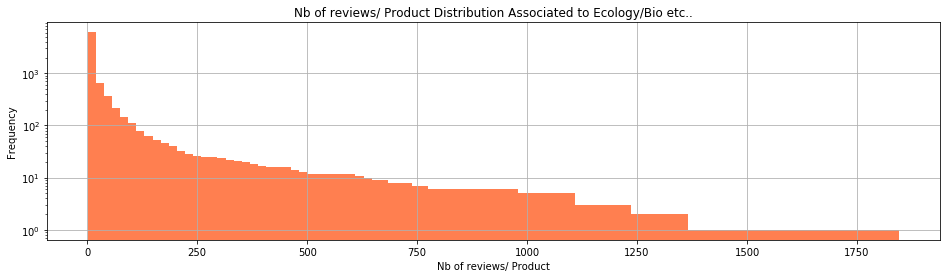

In [245]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_size_inches(16,4)

nbreviews_Pandas.hist(log=True, bins = 100, color="coral", cumulative=-1,figsize =(16,4), ax=axes)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")